In [39]:
import pickle

exports_dir = '../exports/en-tw-transformer-nmt'
training_sample = 100
num_attention_layers = 4

In [40]:
from datetime import date

model_plot = f'{exports_dir}/en-tw.png'
checkpoint_filepath = exports_dir + f'/checkpoint.weights.{date.today()}.' + '{epoch:02d}-{val_loss:.2f}.keras'
checkpoint_filepath_best = exports_dir + '/checkpoint.weights.best.keras'
model_file = f'{exports_dir}/models.pkb'

In [41]:
import os

os.makedirs(exports_dir, exist_ok=True)

In [42]:
from archive.lib import loaders

inp_lang, targ_lang = loaders.en_tw(training_sample)
inp_lang.save(exports_dir)
targ_lang.save(exports_dir)
print(inp_lang, '\n', targ_lang)

LanguageIndex { sequences: 100, vocab_size: 352, max_sequence_timestep: 35, vocab: ('!', "'", ',', '.', '?'...) } 
 LanguageIndex { sequences: 100, vocab_size: 412, max_sequence_timestep: 30, vocab: ('!', "'", ',', '.', '?'...) }


In [43]:
from archive.lib.utils import tf_embedding_scale, create_positional_encoding
from archive.lib.layers.dense import FeedForward
from archive.lib.layers.attention import SelfAttention, MaskedSelfAttention, CrossAttention
from keras import layers
from archive.lib.models import graph

embed_dim = 512
max_expected_user_response = 1024

position_vectors = create_positional_encoding(max_seq_len=max_expected_user_response, embed_dim=embed_dim)

model = graph.Graph(
    inputs=[
        layers.Input(shape=(inp_lang.max_timesteps,), name='english_input'),
        layers.Input(shape=(targ_lang.max_timesteps,), name='twi_input')
    ],
    layers=[
        # Encoder Positional Embedding
        layers.Embedding(name='encoder_embedding', input_dim=inp_lang.vocab_size, output_dim=embed_dim, mask_zero=True),
        layers.Lambda(name='encoder_embeddings_scaled', function=tf_embedding_scale(embed_dim)),
        layers.Lambda(name='encoder_positions',
                      function=lambda x: x + position_vectors[:x.shape[0], :x.shape[1], :x.shape[2]]),

        layers.Dropout(name='encoder_dropout', rate=0.1),

        SelfAttention(name="encoder_attention", num_heads=8, key_dim=embed_dim, dropout=0.1),
        FeedForward(name="encoder_feedforward", d_model=embed_dim, dff=2048),

        # Decoder Positional Embedding
        layers.Embedding(name='decoder_embedding', input_dim=targ_lang.vocab_size, output_dim=embed_dim,
                         mask_zero=True),
        layers.Lambda(name='decoder_embeddings_scaled', function=tf_embedding_scale(embed_dim)),
        layers.Lambda(name='decoder_positions',
                      function=lambda x: x + position_vectors[:x.shape[0], :x.shape[1], :x.shape[2]]),

        layers.Dropout(name='decoder_dropout', rate=0.1),

        MaskedSelfAttention(name="decoder_masked_attention", num_heads=8, key_dim=embed_dim, dropout=0.1),
        CrossAttention(name="decoder_cross_attention", num_heads=8, key_dim=embed_dim, dropout=0.1),
        FeedForward(name="decoder_feedforward", d_model=embed_dim, dff=2048),

        layers.Dense(targ_lang.vocab_size, activation='softmax', name='output')
    ],
    connections=[
        # Encoder
        ('english_input', 'encoder_embedding'),
        ('encoder_embedding', 'encoder_embeddings_scaled'),
        ('encoder_embeddings_scaled', 'encoder_positions'),

        ('encoder_positions', 'encoder_dropout'),
        ('encoder_dropout', 'encoder_attention'),
        ('encoder_attention', 'encoder_feedforward'),

        # Bridge - Encoder's output goes to decoder as context
        ('encoder_feedforward', 'decoder_cross_attention[context]'),

        # Decoder
        ('twi_input', 'decoder_embedding'),
        ('decoder_embedding', 'decoder_embeddings_scaled'),
        ('decoder_embeddings_scaled', 'decoder_positions'),

        ('decoder_positions', 'decoder_dropout'),
        ('decoder_dropout', 'decoder_masked_attention'),
        ('decoder_masked_attention', 'decoder_cross_attention[x]'),
        ('decoder_cross_attention', 'decoder_feedforward'),

        ('decoder_feedforward', 'output')
    ]
)

[<KerasTensor: shape=(None, 35) dtype=float32 (created by layer 'english_input')>, <KerasTensor: shape=(None, 30) dtype=float32 (created by layer 'twi_input')>]


In [44]:
model.summary()

Model: "graph_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 english_input (InputLayer)  [(None, 35)]                 0         []                            
                                                                                                  
 twi_input (InputLayer)      [(None, 30)]                 0         []                            
                                                                                                  
 encoder_embedding (Embeddi  (None, 35, 512)              180224    ['english_input[0][0]']       
 ng)                                                                                              
                                                                                                  
 decoder_embedding (Embeddi  (None, 30, 512)              210944    ['twi_input[0][0]']     

In [45]:
if os.path.exists(checkpoint_filepath):
    model.load_weights(checkpoint_filepath)

In [46]:
from archive.lib.utils import masked_loss, TransformerLearningRateSchedule
from keras import optimizers

model.compile(
    loss=masked_loss,
    optimizer=optimizers.legacy.Adam(
        TransformerLearningRateSchedule(embed_dim), beta_1=0.9, beta_2=0.98, epsilon=1e-9)
)

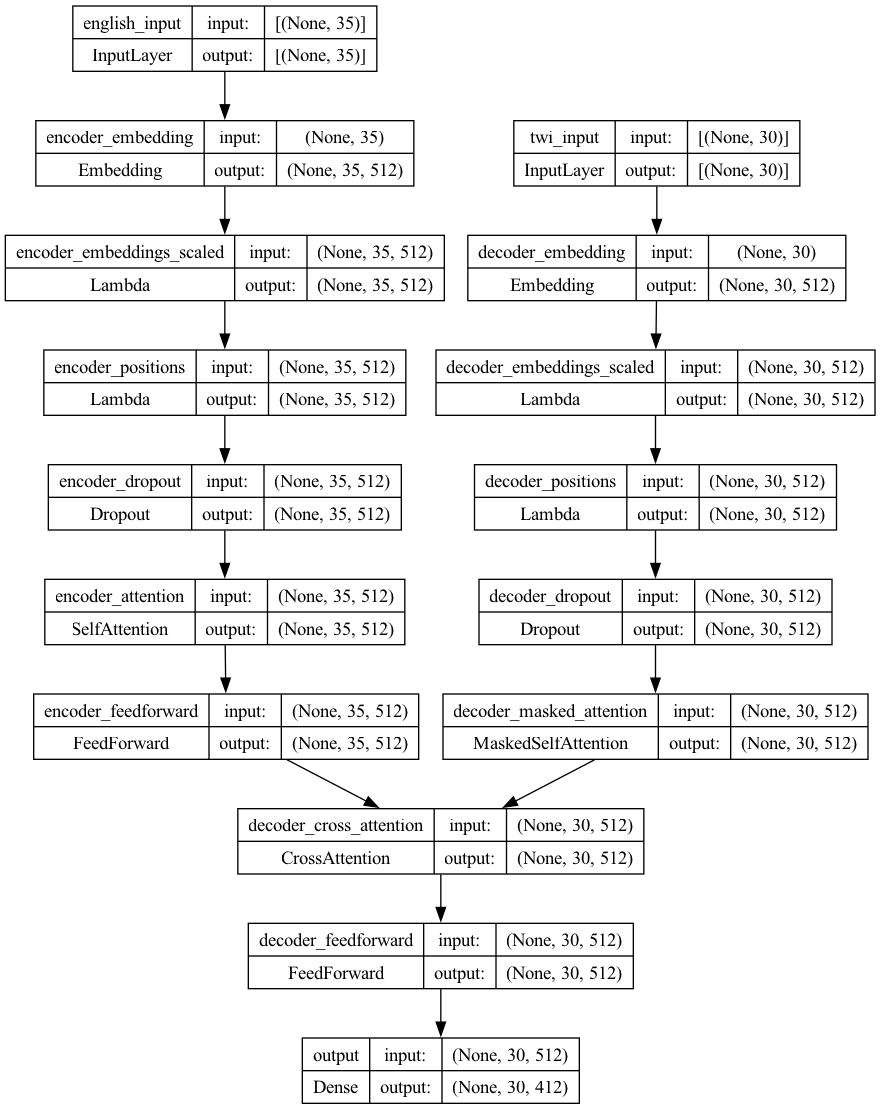

In [47]:
from keras import utils

utils.plot_model(model, to_file=f'{exports_dir}/en-tw.png', show_shapes=True, show_layer_names=True,
                 expand_nested=True)

In [48]:
from keras import callbacks

checkpoint_callback = callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_best_only=True,
                                                      save_weights_only=True)
checkpoint_callback_best = callbacks.ModelCheckpoint(filepath=checkpoint_filepath_best, save_best_only=True,
                                                save_weights_only=True)

In [49]:
data = inp_lang.tensor(), targ_lang.tensor(shift='start')
model.fit(data, targ_lang.tensor(), epochs=10, validation_split=0.2, callbacks=[checkpoint_callback, checkpoint_callback_best])

Epoch 1/10


/opt/homebrew/anaconda3/lib/python3.11/site-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


3/3 [==============================] - 4s 955ms/step - loss: 6.4715 - val_loss: 6.5331
Epoch 2/10
3/3 [==============================] - 2s 523ms/step - loss: 6.4835 - val_loss: 6.5234
Epoch 3/10
3/3 [==============================] - 2s 687ms/step - loss: 6.4540 - val_loss: 6.5066
Epoch 4/10
3/3 [==============================] - 2s 590ms/step - loss: 6.4557 - val_loss: 6.4827
Epoch 5/10
3/3 [==============================] - 2s 677ms/step - loss: 6.4045 - val_loss: 6.4521
Epoch 6/10
3/3 [==============================] - 2s 581ms/step - loss: 6.3634 - val_loss: 6.4149
Epoch 7/10
3/3 [==============================] - 1s 492ms/step - loss: 6.3240 - val_loss: 6.3713
Epoch 8/10
3/3 [==============================] - 2s 533ms/step - loss: 6.2537 - val_loss: 6.3222
Epoch 9/10
3/3 [==============================] - 2s 687ms/step - loss: 6.2002 - val_loss: 6.2684
Epoch 10/10
3/3 [==============================] - 2s 539ms/step - loss: 6.1334 - val_loss: 6.2098


In [50]:
with open(model_file, mode='wb') as f:
    pickle.dump(model, f)